In [1]:
library(gdata)
library(ggplot2)
library(grid)
library(gridExtra)

gdata: read.xls support for 'XLS' (Excel 97-2004) files ENABLED.

gdata: read.xls support for 'XLSX' (Excel 2007+) files ENABLED.

Attaching package: ‘gdata’

The following object is masked from ‘package:stats’:

    nobs

The following object is masked from ‘package:utils’:

    object.size

The following object is masked from ‘package:base’:

    startsWith


Attaching package: ‘gridExtra’

The following object is masked from ‘package:gdata’:

    combine



In [2]:
GBD <- read.table("../Data/DALY_YLL_deaths_per_region_and_27_diseases_2005.txt")
RCT <- read.table("../Data/RCTs_and_Patients_prop_among_all_and_HI_median_UI_across_regions_per_disease.txt")
GBD <- GBD[order(GBD$Region,GBD$Disease),]
RCT <- RCT[order(RCT$Region,RCT$Disease),]

In [3]:
ratio_align <- read.table("../Data/Alignment_ratios_within_diseases_across_all_NHI_patients_metrs_burdens.txt")

In [4]:
levels(GBD$Disease)

[1] "all"                                                                                     
 [2] "Cardiovascular and circulatory diseases"                                                 
 [3] "Chronic respiratory diseases"                                                            
 [4] "Cirrhosis of the liver"                                                                  
 [5] "Congenital anomalies"                                                                    
 [6] "Diabetes, urinary diseases and male infertility"                                         
 [7] "Diarrhea, lower respiratory infections, meningitis, and other common infectious diseases"
 [8] "Digestive diseases (except cirrhosis)"                                                   
 [9] "Gynecological diseases"                                                                  
[10] "Hemoglobinopathies and hemolytic anemias"                                                
[11] "Hepatitis"                                                                               
[12] "HIV/AIDS"                                                                                
[13] "Leprosy"                                                                                 
[14] "Malaria"                                                                                 
[15] "Maternal disorders"                                                                      
[16] "Mental and behavioral disorders"                                                         
[17] "Musculoskeletal disorders"                                                               
[18] "Neglected tropical diseases excluding malaria"                                           
[19] "Neonatal disorders"                                                                      
[20] "Neoplasms"                                                                               
[21] "Neurological disorders"                                                                  
[22] "Nutritional deficiencies"                                                                
[23] "Oral disorders"                                                                          
[24] "Sense organ diseases"                                                                    
[25] "Sexually transmitted diseases excluding HIV"                                             
[26] "Skin and subcutaneous diseases"                                                          
[27] "Sudden infant death syndrome"                                                            
[28] "Tuberculosis"

In [5]:
#Disease labels for plot
GBD$Dis_lab <- GBD$Disease
levels(GBD$Dis_lab) <- c("",
               "Cardiovascular and circulatory diseases",
               "Chronic respiratory diseases",
               "Cirrhosis of the liver",
               "Congenital anomalies",
               "Diabetes, urinary diseases, male infertility",
               "Common infectious diseases",
               "Digestive diseases",
               "Gynecological diseases",
               "Hemoglob. and\nhemolytic anemia",
               "Hepatitis",
               "HIV/AIDS",
               "Leprosy",
               "Malaria",
               "Maternal disorders",
               "Mental and behavioral disorders",
               "Musculoskeletal disorders",
               "Neglected tropical diseases",
               "Neonatal disorders",
               "Neoplasms",
               "Neurological disorders",
               "Nutritional deficiencies",
               "Oral disorders",
               "Sense organ diseases",
               "Sexually transmitted diseases",
               "Skin and subcutaneous diseases",
               "Sudden infant death syndrome",
               "Tuberculosis")

In [6]:
RCT$Dis_lab <- RCT$Disease
levels(RCT$Dis_lab) <- unique(as.character(GBD$Dis_lab))[levels(droplevels(GBD$Disease[GBD$Dis_lab!=""]))%in%levels(RCT$Disease)]

In [7]:
dis <- levels(RCT$Disease)

In [8]:
regs <- levels(RCT$Region)
#Non-High-income burden
gbd_t_r <- GBD[GBD$Disease=="all" & GBD$metr=="daly" & GBD$Region!="High-income",]

In [9]:
regs <- c("High-income", "Non-HI", as.character(gbd_t_r$Region)[order(gbd_t_r$burden)])
regs

[1] "High-income"                                     
[2] "Non-HI"                                          
[3] "North Africa and Middle East"                    
[4] "Latin America and Caribbean"                     
[5] "Central Europe, Eastern Europe, and Central Asia"
[6] "Southeast Asia, East Asia and Oceania"           
[7] "Sub-Saharian Africa"                             
[8] "South Asia"

In [10]:
regs_lab <- c("High-income",
             "Non-    \nhigh-income",
             "North Africa\nMiddle East",
             "Latin America",
             "Eastern Europe\nCentral Asia",
             "Southeast Asia\nOceania",
             "Sub-Saharian\nAfrica",
             "South Asia")

In [11]:
#10 diseases with highest burden
bglob_dis <- GBD[GBD$Region=="All" & GBD$metr=="daly",]
bglob_dis <- bglob_dis[order(bglob_dis$burden,decreasing = TRUE),]
dis <- as.character(bglob_dis$Disease)[1:10]

In [12]:
#For annotating with ratio of alignment
form <- function(x){
paste(format(round(x[2]),nsmall = 0),
           " [",format(round(x[1]),nsmall = 0),
           "-",format(round(x[3]),nsmall = 0),"]")
    }

In [13]:
L <- list()
for(i in 1:length(dis)){
    d <- dis[i]
    dlab <- unique(as.character(GBD$Dis_lab[GBD$Disease==d]))
    burd_tot <- GBD$burden[GBD$metr=="daly" & GBD$Disease==d & GBD$Region=="All"]

    #Global burden of disease d across regions
    dfb <- GBD[GBD$metr=="daly" & GBD$Disease==d & GBD$Region!="All",]
    dfb$prop <- 100*dfb$burden/burd_tot
    dfb$mes <- "burden"
    dfb <- dfb[,c("Region","prop","mes")] 
    dfb <- rbind(dfb,
    data.frame(Region="Non-HI",prop=sum(dfb$prop[dfb$Region!="High-income"]),
           mes="burden"))

    #Global research on d across regions
    dfr <- RCT[RCT$Disease==d,]
    dfr$prop <- dfr$Prop_all_RCTs_med
    dfr$mes <- "research"
    dfr <- dfr[,c("Region","prop","mes")]
    dt <- rbind(dfb,dfr)    

    #Uncertainty intervals for global research share across regions
    dfre <- RCT[RCT$Disease==d,]
    dfre$prop_low <- dfre$Prop_all_RCTs_low
    dfre$prop_up <- dfre$Prop_all_RCTs_up
    dfre$mes <- "research"
    dfre <- dfre[,c("Region","prop_low","prop_up","mes")]    
    
    #Order of regions:
    dt$Region <- reorder(dt$Region,new.order=regs)
    dfre$Region <- reorder(dfre$Region,new.order=as.character(regs))
    dt$Reg_lab <- dt$Region
    levels(dt$Reg_lab) <- regs_lab

    dlbl <- dt[order(dt$Region),]
    dlbl <- dlbl[!duplicated(dlbl$Region),]

    #GGPLOT Object
    p <- ggplot(dt,aes(Region))
    p <- p + geom_bar(aes(fill=mes,y=prop),position="dodge",stat="identity",width=0.8)
#    p <- p + geom_segment(aes(x=as.numeric(Region)-0.4,xend=as.numeric(Region)+0.4,y=prop/2,yend=prop/2,size=5),linetype="dashed",data=dt[dt$mes=="burden",],lwd=0.1)
    p <- p + geom_errorbar(aes(x=as.numeric(Region)+0.2,ymax=prop_up,ymin=prop_low),width=0.2,data=dfre)
    p <- p + scale_fill_manual(values = c("burden"="orange","research"="blue"))

    p <- p + scale_x_discrete(label = dlbl$Reg_lab
                             )


    if(i%%2==1){
    p <- p + scale_y_continuous(limits = c(0,100),breaks=seq(0,100,10),
                                name=paste("Global share (%)\nof burden and research")
                                )
    }
    else {p <- p + scale_y_continuous(limits = c(0,100),breaks=seq(0,100,10),
                                name=paste("\n")
                                )
        }

    p <- p + ggtitle(dlab)
    p <- p + theme( axis.text.x = element_text(
#                    face=dlbl$gap_text,
                    angle=55,
                    hjust=1,
                    vjust=1.1,size=8)) +
             theme(panel.background = element_blank()) + 
             theme(panel.grid.major.y = element_line(colour = "grey",size=0.1)) +
             theme(panel.grid.major.x = element_blank()) + 
             theme(axis.ticks.x=element_blank()) + 
             theme(legend.position = "none") + 
             theme(axis.title.x=element_blank())

    p <- p + annotate("text",x=(length(regs)+1)/2,y=95,label=
                paste("R =",
                 form(ratio_align[ratio_align$Disease==as.character(dis[i]),
                   intersect(grep("all",names(ratio_align)),
                             intersect(grep("RCT",names(ratio_align)),
                                       grep("daly",names(ratio_align))))]) )
                )
    L[[i]] <- p

}

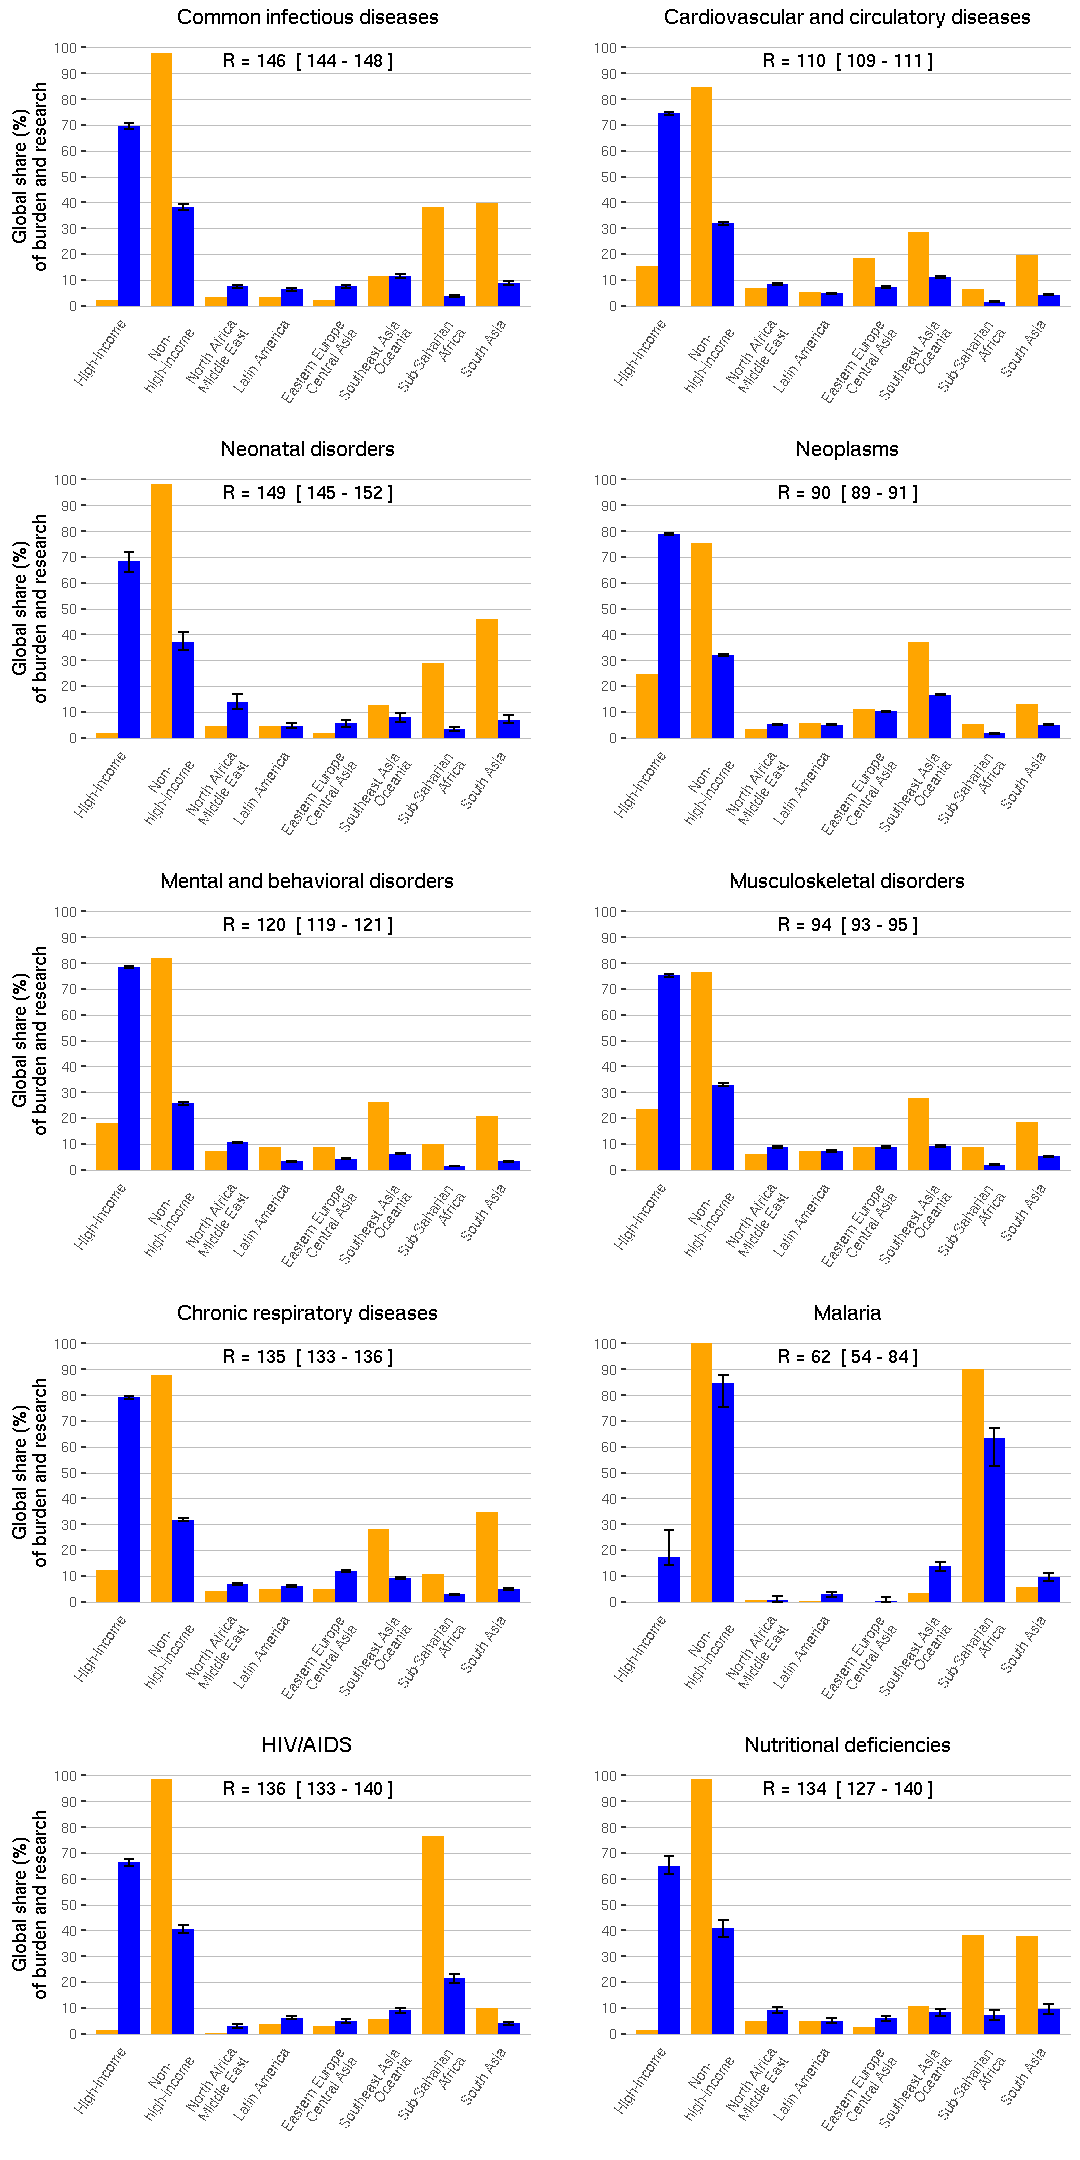

In [14]:
options(repr.plot.width=9, repr.plot.height=18)

grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]],L[[9]],L[[10]], ncol=2)

In [15]:
ggsave(filename = "../Figures/RCTs_vs_DALYs_withindis.pdf",
       plot=grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]],L[[9]],L[[10]], ncol=2),
       width=9,height=18)

# Share research vs burden across Non-high-income regions

In [16]:
bNHI_dis <- tapply(GBD$burden[GBD$Region!="All" & GBD$Region!="High-income" & GBD$metr=="daly" & GBD$Disease!="all"],
                    GBD$Disease[GBD$Region!="All" & GBD$Region!="High-income" & GBD$metr=="daly" & GBD$Disease!="all"],sum)

In [17]:
dis <- names(sort(bNHI_dis,decreasing=TRUE)[1:10])

In [18]:
regs <- c(as.character(gbd_t_r$Region)[order(gbd_t_r$burden)])
regs

[1] "North Africa and Middle East"                    
[2] "Latin America and Caribbean"                     
[3] "Central Europe, Eastern Europe, and Central Asia"
[4] "Southeast Asia, East Asia and Oceania"           
[5] "Sub-Saharian Africa"                             
[6] "South Asia"

In [19]:
regs_lab <- c("North Africa\nMiddle East",
             "Latin America",
             "Eastern Europe\nCentral Asia",
             "Southeast Asia\nOceania",
             "Sub-Saharian\nAfrica",
             "South Asia")

In [20]:
L <- list()
for(i in 1:length(dis)){
    d <- dis[i]
    dlab <- unique(as.character(GBD$Dis_lab[GBD$Disease==d]))
    burd_tot <- sum(GBD$burden[GBD$metr=="daly" & GBD$Disease==d & GBD$Region!="All" & GBD$Region!="High-income"])
    #Global burden of disease d across regions
    dfb <- GBD[GBD$metr=="daly" & GBD$Disease==d & GBD$Region!="All" & GBD$Region!="High-income",]
    dfb$prop <- 100*dfb$burden/burd_tot
    dfb$mes <- "burden"
    dfb <- dfb[,c("Region","prop","mes")] 

    #Global research on d across regions
    dfr <- RCT[RCT$Disease==d & RCT$Region!="High-income" & RCT$Region!="Non-HI",]
    dfr$prop <- dfr$Prop_NHI_RCTs_med
    dfr$mes <- "research"
    dfr <- dfr[,c("Region","prop","mes")]
    dt <- rbind(dfb,dfr)    

    #Uncertainty intervals for global research across regions
    dfre <- RCT[RCT$Disease==d & RCT$Region!="High-income" & RCT$Region!="Non-HI",]
    dfre$prop_low <- dfre$Prop_NHI_RCTs_low
    dfre$prop_up <- dfre$Prop_NHI_RCTs_up
    dfre$mes <- "research"
    dfre <- dfre[,c("Region","prop_low","prop_up","mes")]    
    
    #Order of regions:
    dt$Region <- reorder(dt$Region,new.order=regs)
    dfre$Region <- reorder(dfre$Region,new.order=as.character(regs))
    dt$Reg_lab <- dt$Region
    levels(dt$Reg_lab) <- regs_lab

    #Highlighting GAPS
    dt$gap <- dt$Region
    levels(dt$gap) <- unlist(lapply(levels(dt$Region),
                                    function(x){
                                        ifelse(sum(dfre$Region==x)==0,NA,
                                        dt$prop[dt$mes=="burden" & dt$Region==x]/
                                        dfre$prop_up[dfre$Region==x])}))
    dt$gap_col <- dt$mes
    dt$gap_col[as.numeric(as.character(dt$gap))>=2 & dt$gap_col=="burden"] <- "burden_gap"
    
    dlbl <- dt[order(dt$Region),]
    dlbl <- dlbl[dlbl$mes=="burden",]
    dlbl$gap_text <- "plain"
    dlbl$gap_text[dlbl$gap_col=="burden_gap"] <- "bold"

    
    #GGPLOT Object
    p <- ggplot(dt,aes(Region))
    p <- p + geom_bar(aes(fill=gap_col,y=prop),position="dodge",stat="identity",width=0.8)
    p <- p + geom_segment(aes(x=as.numeric(Region)-0.4,xend=as.numeric(Region)+0.4,y=prop/2,yend=prop/2,size=5),linetype="dashed",data=dt[dt$mes=="burden",],lwd=0.1)
    p <- p + geom_errorbar(aes(x=as.numeric(Region)+0.2,ymax=prop_up,ymin=prop_low),width=0.2,data=dfre)
    p <- p + scale_fill_manual(values = c("burden"="orange","burden_gap"="red","research"="blue"))

    p <- p + scale_x_discrete(label = dlbl$Reg_lab)

    if(i%%2==1){
    p <- p + scale_y_continuous(limits = c(0,95),breaks=seq(0,90,10),
                                name=paste("Share among non-high-income (%)\nof burden and research")
                                )
    }
    else {p <- p + scale_y_continuous(limits = c(0,95),breaks=seq(0,90,10),
                                name=paste("\n")
                                )
        }

    p <- p + ggtitle(dlab)
    p <- p + theme( axis.text.x = element_text(
                    face=dlbl$gap_text,
                    angle=55,
                    hjust=1,
                    vjust=1.1,size=8)) +
             theme(panel.background = element_blank()) + 
             theme(panel.grid.major.y = element_line(colour = "grey",size=0.1)) +
             theme(panel.grid.major.x = element_blank()) + 
             theme(axis.ticks.x=element_blank()) + 
             theme(legend.position = "none") + 
             theme(axis.title.x=element_blank())

    p <- p + annotate("text",x=(length(regs)+1)/2,y=85,label=
                paste("R =",
                 form(ratio_align[ratio_align$Disease==as.character(dis[i]),
                   intersect(grep("NHI",names(ratio_align)),
                             intersect(grep("RCT",names(ratio_align)),
                                       grep("daly",names(ratio_align))))]) )
                )
    
    L[[i]] <- p

}


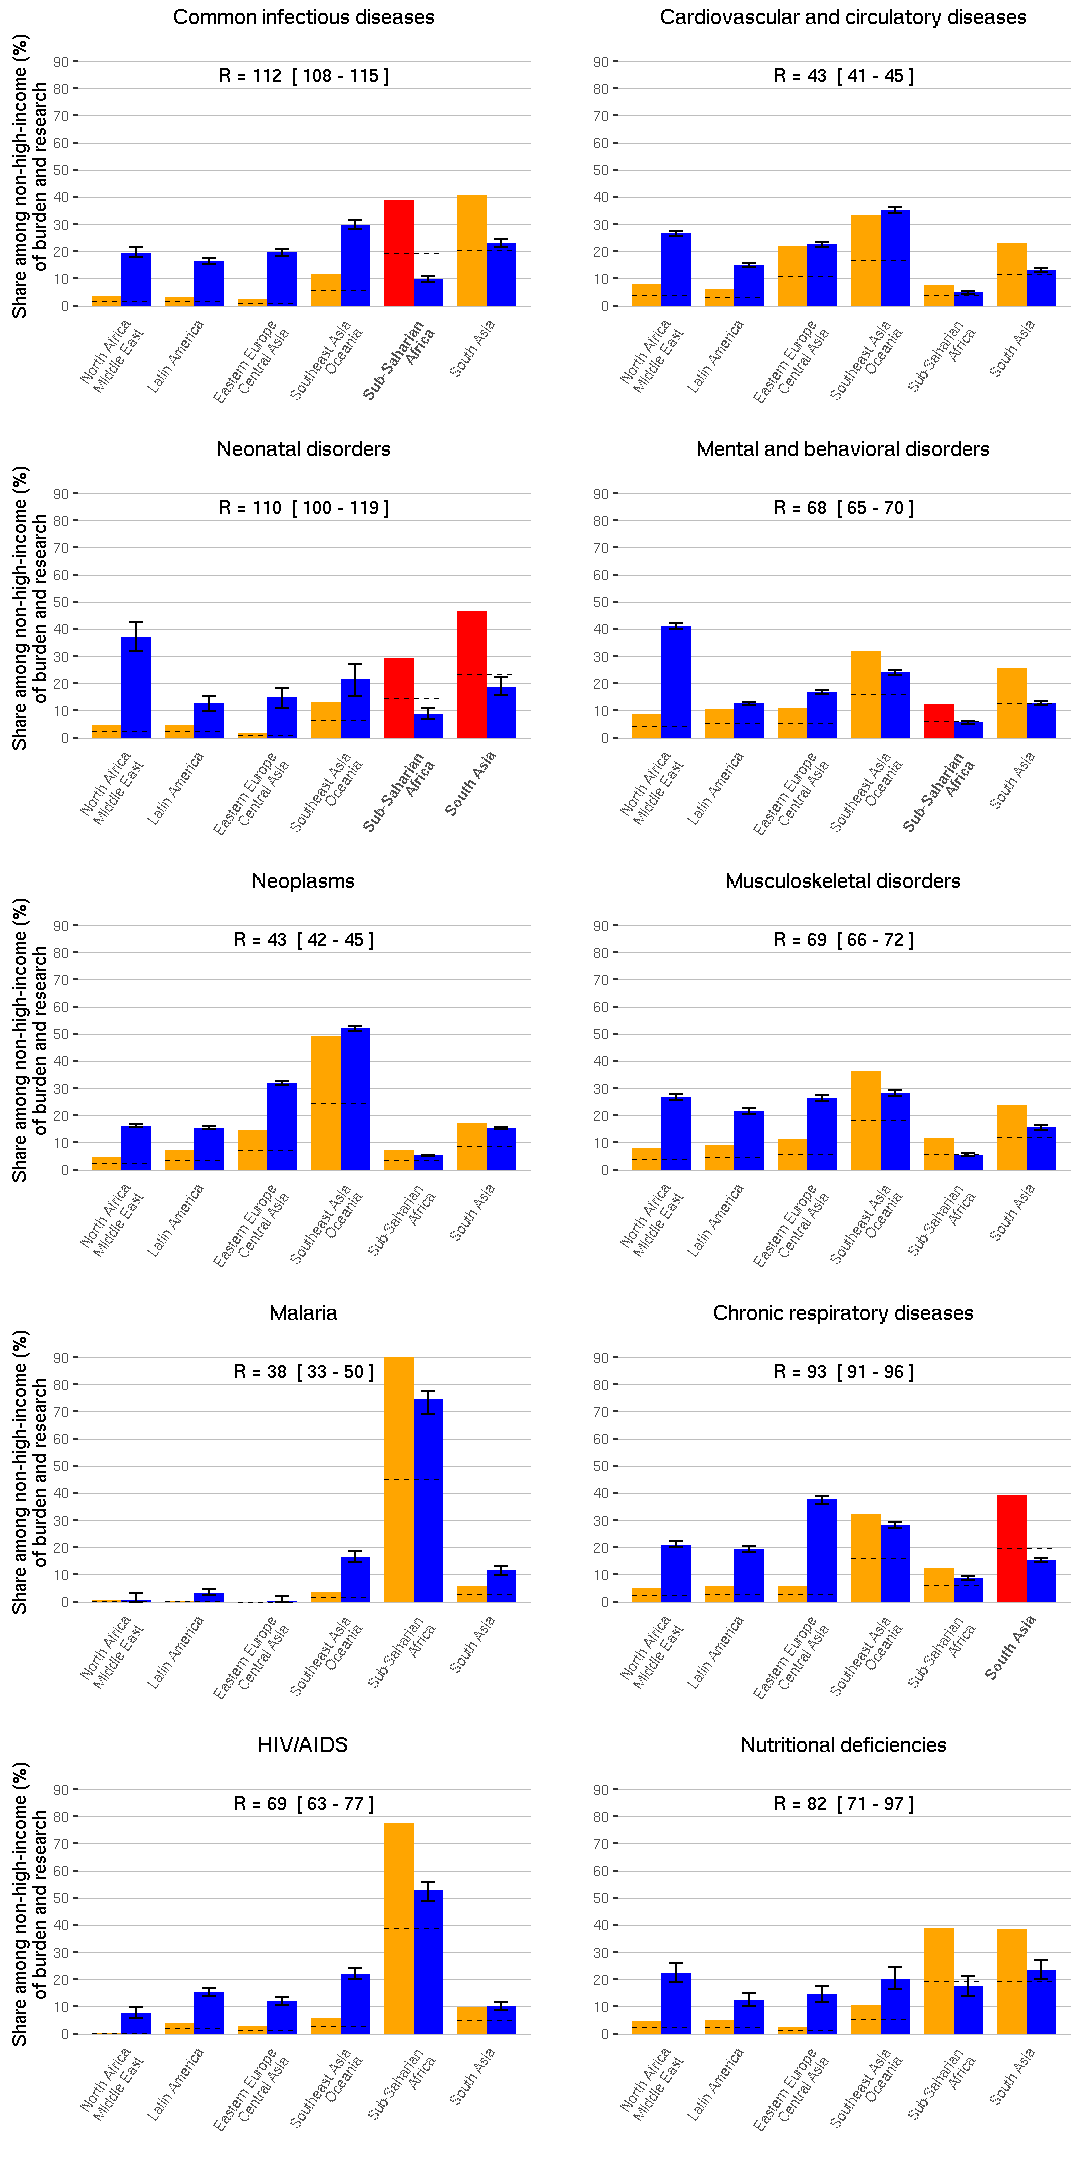

In [21]:
options(repr.plot.width=9, repr.plot.height=18)

grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]],L[[9]],L[[10]], ncol=2)

In [22]:
ggsave(filename = "../Figures/RCTs_vs_DALYs_withindis_NonHI.pdf",
       plot=grid.arrange(L[[1]],L[[2]],L[[3]],L[[4]],L[[5]],L[[6]],L[[7]],L[[8]],L[[9]],L[[10]], ncol=2),
       width=9,height=18)